In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
from datetime import datetime
from dateutil.parser import parse
from itertools import chain
import operator
import sys
from fbprophet import Prophet


In [2]:
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)

In [3]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [4]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [5]:
btc_usd_price_kraken.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-01-13,14101.0,17200.0,13266.3,14400.0,1182.992487,1.708698e+07,14443.863557
2018-01-14,14396.3,14500.0,13209.6,13711.2,2431.932685,3.342053e+07,13742.376128
2018-01-15,13711.1,14438.9,13207.0,13608.3,3531.910480,4.905487e+07,13889.047827
2018-01-16,13606.9,13633.1,10111.0,11533.2,10021.923820,1.181083e+08,11784.994745
2018-01-17,11533.9,11968.9,9225.0,10900.0,11013.028471,1.159190e+08,10525.626956


In [6]:
# Chart the BTC pricing data
btc_trace = go.Scatter(x=btc_usd_price_kraken.index, y=btc_usd_price_kraken['Weighted Price'])
py.iplot([btc_trace])

In [7]:
# Pull pricing data for 3 more BTC exchanges
# ADD YALE/SPCOMP
exchanges = ['COINBASE','BITSTAMP','ITBIT']


exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    if exchange == 'SPCOMP':
        exchange_code = 'YALE/{}'.format(exchange)
    else:    
        exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [8]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [9]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')

In [10]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [11]:
btc_usd_datasets.tail()

,BITSTAMP,COINBASE,ITBIT,KRAKEN
Date,,,,
2018-01-13,14233.654008,14202.494478,14256.959157,14443.863557
2018-01-14,13544.440953,13633.659200,13619.433483,13742.376128
2018-01-15,13875.586308,13831.601515,13850.189661,13889.047827
2018-01-16,11800.132584,11738.709333,11898.419508,11784.994745
2018-01-17,10459.667942,10513.544365,NaN,10525.626956


In [12]:
# Plot all of the BTC exchange prices
#go.scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

In [13]:
#Pull Stock Market Data
#YALE/SPCOMP

In [14]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [15]:
#Start Regression
reg_data = exchange_data['KRAKEN']['20170414':'20180126'].loc[:,['Open','High', 'Low', 'Close', 'Volume (BTC)' , 'Volume (Currency)', 'Weighted Price']]

In [16]:
reg_data.tail()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Date,,,,,,,
2018-01-13,14101.0,17200.0,13266.3,14400.0,1182.992487,1.708698e+07,14443.863557
2018-01-14,14396.3,14500.0,13209.6,13711.2,2431.932685,3.342053e+07,13742.376128
2018-01-15,13711.1,14438.9,13207.0,13608.3,3531.910480,4.905487e+07,13889.047827
2018-01-16,13606.9,13633.1,10111.0,11533.2,10021.923820,1.181083e+08,11784.994745
2018-01-17,11533.9,11968.9,9225.0,10900.0,11013.028471,1.159190e+08,10525.626956


In [17]:
reg_data['y'] = np.log(reg_data['Close'])
reg_data['ds'] = reg_data.index
fb_reg_data = reg_data.loc[:,['ds','y']]
fb_reg_data = fb_reg_data.reset_index(drop=True)
fb_reg_data.dropna(inplace=True)
fb_reg_data.head()

,ds,y
0,2017-04-14,7.080019
1,2017-04-15,7.069030
2,2017-04-16,7.074115
3,2017-04-17,7.087991
4,2017-04-18,7.092057


In [18]:
from fbprophet import Prophet
import seaborn as sns
import matplotlib.dates as mdates

In [19]:
def plot_data1(df,X,future,columns,title):
    
# lot_data(predicted, actual, future, col
    x=X['ds']
    y=X['y']
    print(x)

In [20]:
def plot_data(df,X,future,columns,title):

# lot_data(predicted, actual, future, cols,title)
    trace1 = go.Scatter(
        x=future['ds'],
        y=X,
        name='Actual Close'
    )
    #Lower_closing	Upper_closing
    trace2 = go.Scatter(
        x=future['ds'],
        y=df['Upper_closing'],
        name='Predicted Close Upper Bound',
        fill=None,
        mode='lines',
        line=dict(color='rgb(143,19,131)'),        
       
    )
    trace3 = go.Scatter(
        x=future['ds'],
        y=df['Lower_closing'],
        name='Predicted Close Lower Bound',
        fill='tonexty',
        mode='lines',
        line=dict(color='rgb(143,19,131)'),
    )

    data = [trace1, trace2, trace3]
    layout = go.Layout(
        title='Actual Vs Predicted using FBProphet',
        yaxis=dict(
            title='Closing Price'
        ),
        yaxis2=dict(
            title='yaxis2 title',
            titlefont=dict(
                color='rgb(148, 103, 189)'
            ),
            tickfont=dict(
                color='rgb(148, 103, 189)'
            ),
            overlaying='y',
            side='right'
        )
    )
    fig = go.Figure(data=data, layout=layout)
    #plot_url = py.plot(fig)
    py.iplot(fig)
    #plt.show()

In [22]:

m = Prophet()
m.fit(fb_reg_data)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
predicted  = forecast[['yhat', 'yhat_lower', 'yhat_upper']].applymap(np.exp)

   

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\kundami\Anaconda3\envs\PythonData\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [23]:
future.tail()

,ds
302,2018-02-10
303,2018-02-11
304,2018-02-12
305,2018-02-13
306,2018-02-14


In [24]:
##https://facebook.github.io/prophet/docs/quick_start.html

# Python
#m = Prophet(changepoints=['2017-11-12', '2017-12-16', '2017-12-30'])
#forecast = m.fit(fb_reg_data).predict(future)
#m.plot(forecast)

m = Prophet(changepoint_prior_scale = 0.5)
m.fit(fb_reg_data)
future = m.make_future_dataframe(periods=28)
forecast = m.predict(future)
predicted  = forecast[['yhat', 'yhat_lower', 'yhat_upper']].applymap(np.exp)
cols = ["Mean", "Lower_closing", "Upper_closing"]
predicted.columns = cols
actual = np.exp(fb_reg_data["y"])
#actual = actual[::-1]
actual.name = "Actual"
title = "Closing price distribution of bitcoin"
plot_data(predicted, actual, future, cols,title)


INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\kundami\Anaconda3\envs\PythonData\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



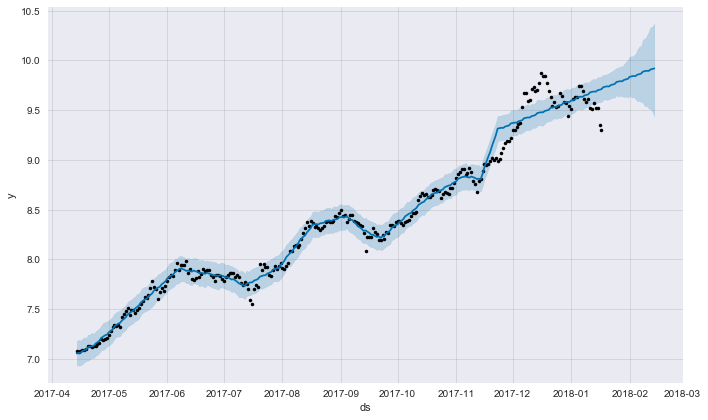

In [25]:
m.plot(forecast)

In [26]:
predicted = forecast[['yhat_lower', 'yhat_upper']].applymap(np.exp)
acc = 1
err = 1
for x, y in zip(predicted[['yhat_lower', 'yhat_upper']].values,actual):
    if x[0] <= y and  y <= x[1]:
        acc+=1
    else :
        err+=1
print(acc/len(actual))
print(err/len(actual))


0.8673835125448028
0.13978494623655913


In [27]:
#actual.values
m.plot_components(forecast);

In [28]:
fb_reg_data.head()

,ds,y
0,2017-04-14,7.080019
1,2017-04-15,7.069030
2,2017-04-16,7.074115
3,2017-04-17,7.087991
4,2017-04-18,7.092057


In [88]:
future.tail()

,ds
654,2018-01-18
655,2018-01-19
656,2018-01-20
657,2018-01-21
658,2018-01-22


In [89]:
predicted.tail()

,yhat_lower,yhat_upper
654,16026.037657,21096.650335
655,15923.075262,21598.896938
656,16301.971452,21445.113124
657,16466.740150,22009.625606
658,16735.940026,22404.290301
